# Multiclass classification with Softmax Regression

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import ssl
np.random.seed(42)

# Load & Transform MNIST dataset

### Download the data

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
mnist = fetch_openml('mnist_784', version=1, parser='auto')

### Data Partitioning
Split the data into training and test sets.
The training set will be used to train the model while the test
set will be used to evaluate the model's performance on unseen data.

* split - I chose to split the data into 80% training and 20% test sets (according to the task description)
* shuffle - I choose to the data before splitting it into training and test sets
* stratify - I chose to stratify the data to ensure that the training and test sets have approximately the same percentage of samples of each target class as the complete set.

In [3]:
# X is the data, y is the label
X, y = mnist['data'], mnist['target']
# Split data into train and test set with shuffle and stratify for equal distribution of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, shuffle=True, stratify=y)
y_train = np.array(y_train, dtype=np.int8)
y_test = np.array(y_test, dtype=np.int8)

### Data Transformation
* Flatten the images from 28x28 to 784x1 (already done while loading the data)
* Add a bias term to the data so that each sample is a 785x1 vector
* Normalization - scale the data to have zero mean and unit variance.
* One-hot encode to the labels.


In [4]:
# *The data is already flatten.

# Normalize the data to make the data less senstive to very high or very low values.
X_train = X_train / 255

# Add bias column to X_train and X_test
bias = np.ones((X_train.shape[0], 1))
X_train = np.hstack((bias, X_train))
bias = np.ones((X_test.shape[0], 1))
X_test = np.hstack((bias, X_test))


# One hot encode the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

### Display the data shapes for sanity check and transparency

In [5]:
print(f'X_train shape: {X_train.shape} (type: {type(X_train[0, 0])})')
print(f'X_test shape: {X_test.shape} (type: {type(X_test[0, 0])})')
print(f'y_train shape: {y_train.shape} (type: {type(y_train[0])})')
print(f'y_test shape: {y_test.shape} (type: {type(y_test[0])})')

X_train shape: (60000, 785) (type: <class 'numpy.float64'>)
X_test shape: (10000, 785) (type: <class 'numpy.float64'>)
y_train shape: (60000, 10) (type: <class 'numpy.ndarray'>)
y_test shape: (10000, 10) (type: <class 'numpy.ndarray'>)


# The Softmax Regression Model
* Logistic regression is a binary classifier, so we are using a softmax regression technique in order to classify multiple classes.
* I chose that the fit method stops after a given number of epochs. in each eopch the gradient is calculated and the weights are updated.
* I used vectorized implementation of the softmax regression model using the formula taught in class.
* I chose to initialize the weights to uniform disterbution between -0.1 to 0.1
* The in sample error is calculated using the cross entropy loss function.
* I'm using the test set only to calculate the Eout (out of sample error) during the training process.

In [6]:
class SoftmaxRegression(object):
    def __init__(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = self.get_weights()
        self.labels = self.get_labels()
        self.train_loss, self.test_loss = [], []

    def fit(self, X_train, y_train, X_test, y_test):
        """
            Train the model using the training set.
            calculate the loss for both the training and the test set.    
        """
        N = X_train.shape[0]
        X_test = X_test / 255
        N_test = X_test.shape[0]
        tqdm_epochs = tqdm(range(self.epochs))
        for epoch in tqdm_epochs:
            W = self.weights
            # Linear part
            Z = X_train @ W.T
            # Softmax function (e^x / sum(e^x))
            P = self.softmax(Z)
            # The loss function (cross entropy loss for multiclass classification)
            Ein = - np.sum(np.sum(y_train * np.log(P), axis=1)) / N
            Eout = - np.sum(np.sum(y_test * np.log(self.softmax(X_test @ W.T)), axis=1)) / N_test
            # Gradient of Ein with respect to W. gradient.shape should be d+1 X 1 (which is W.shape)
            gradient = ((P - y_train).T @ X_train).T / N 
            # Update weights
            self.weights -= self.learning_rate * gradient.T
            self.train_loss.append(Ein)
            self.test_loss.append(Eout)
            tqdm_epochs.set_description(f"Epoch: {epoch} with: Ein = {round(Ein, 5)} | Eout = {round(Eout, 5)}")

    def predict(self, X):
        """
            Predict the label for each data point in X.
        """
        scores = self.weights @ X.T
        probs = np.argmax(scores, axis=0)
        return probs
    
    def softmax(self, z):
        """
        This softmax function is used to convert the scores to probabilities.
        It uses the maximum value of each row to avoid overflow.
        its best practice for the exponential function not to be used with large numbers.
        """
        # make sure that z is a 2D array
        assert len(z.shape) == 2
        # take the max of each row
        max = np.max(z, axis=1)
        # add a dimension so that later we can do broadcasting
        max = max[:, np.newaxis]  # necessary step to do broadcasting
        # subtract the max of each row (vector) from each element of the row
        e_x = np.exp(z - max)
        # take the sum of each row
        div = np.sum(e_x, axis=1)
        # add a dimension so that later we can do broadcasting
        div = div[:, np.newaxis]
        # divide each element of each row by the sum of the row
        # which is the softmax
        return e_x / div

    def get_weights(self):
        """
            Initialize the weights with random values between -0.1 and 0.1.
        """
        # init with random vector with uniform distribution
        weights = np.random.uniform(-0.1, 0.1, (10, 785))
        return np.array(weights)

    def get_labels(self):
        """
            Return the labels for the digits.
        """
        return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    def one_hot_to_digit(self, one_hot_array):
        """
            Convert one hot array to digit.
        """
        digit_list = np.argmax(one_hot_array, axis=1)
        return np.array(digit_list)

    def my_confusion_matrix(self, y, y_hats):
        """
            Calculate the:
                confusion matrix.
                accuracy for the whole test set.
                accuracy, sensitivity and selectivity for each digit.
        """
        y = self.one_hot_to_digit(y)
        confusion_mtx = confusion_matrix(y, y_hats)
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=self.labels)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax)
        plt.show()

        # Find true prdiction (where y == y_hats)
        TP = np.sum( y == y_hats)
        accuracy = TP / y.shape[0]
        print('Test set accuracy: ', accuracy)

        for l in self.labels:
            print(f'{l} confusion matrix & metrics:')
            y_l = np.where(y == l, 1, 0)
            y_hats_l = np.where(y_hats == l, 1, 0)

            confusion_mtx = confusion_matrix(y_l, y_hats_l)
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['not ' + str(l), str(l)])
            fig, ax = plt.subplots(figsize=(4, 4))
            disp.plot(ax=ax)
            plt.show()

            # Find true positive (where y_l == 1 and y_hats_l == 1) and y_l == 1
            TP = np.sum(np.logical_and(y_l, y_hats_l))
            # Find true negative (where y_l == 0 and y_hats_l == 0) and y_l == 0
            TN = np.sum(np.logical_and(np.logical_not(y_l), np.logical_not(y_hats_l)))
            # Find false positive (where y_l == 0 and y_hats_l == 1) and y_l == 0
            FP = np.sum(np.logical_and(np.logical_not(y_l), y_hats_l))
            # Find false negative (where y_l == 1 and y_hats_l == 0) and y_l == 1
            FN = np.sum(np.logical_and(y_l, np.logical_not(y_hats_l)))

            sensitivity_TPR = TP / (TP + FN)

            print('sensitivity_TPR: ', sensitivity_TPR)
        
    def plot_loss_for_all_classes(self):
        """
            Plot in and out sample error of all classes in one graph.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax.plot(self.train_loss, label=f'Ein', color=color, linestyle='-')
        ax.plot(self.test_loss, label=f'Eout', color='tab:orange', linestyle='-')
        ax.set_xlabel('epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Cross entropy loss for all classes')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Training

I choose to run the algorithm for 1000 epochs per class.

I've tried the following parameters and the following are the results. I chose the best parameters with the best running time as to my opinion.
* epochs = 1000, learning_rate = 0.1, accuracy = 0.9002.
* epochs = 1000, learning_rate = 0.3, accuracy = 0.91
* epochs = 1000, learning_rate = 0.5, accuracy = 0.9162, Ein = 0.29
* epochs = 1000, learning_rate = 0.8, accuracy = 0.9192, Ein = 0.278

Each time I got differenet results with the same parameters becuase the weights are initialized randomly, and the data at the begining is shuffled.

In [7]:
softmax_regression = SoftmaxRegression(epochs=500, learning_rate=0.5)
softmax_regression.fit(X_train, y_train, X_test, y_test)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 499 with: Ein = 0.30492 | Eout = 0.34248: 100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


# Evaluation
* Evaluate the model's performance on the test set
* Display the confusion matrix
* Display the accuracy (TPR) for each class and the average accuracy (TPR) for all classes

In [8]:
y_hats = softmax_regression.predict(X_test)

* Display the confusion matrix
* Display the accuracy (TPR) for each class and the average accuracy (TPR) for all classes

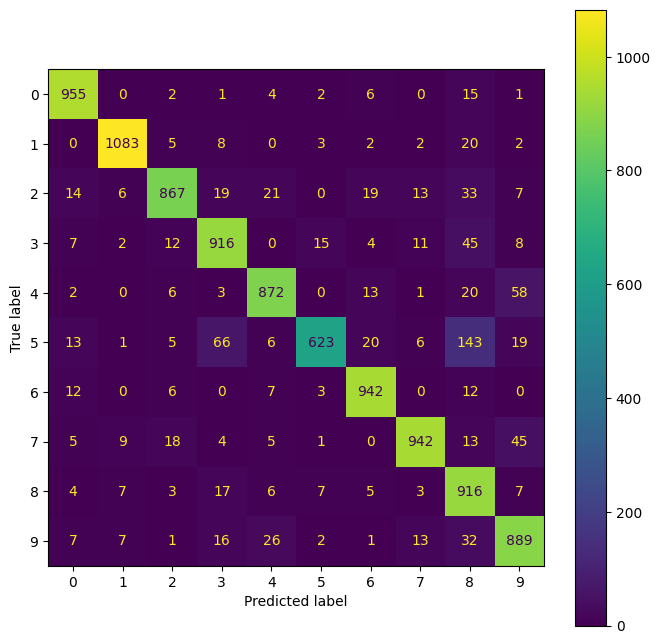

Test set accuracy:  0.9005
0 confusion matrix & metrics:


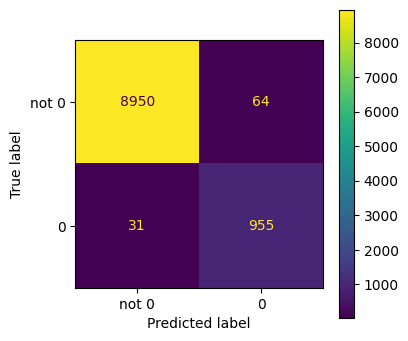

sensitivity_TPR:  0.9685598377281948
1 confusion matrix & metrics:


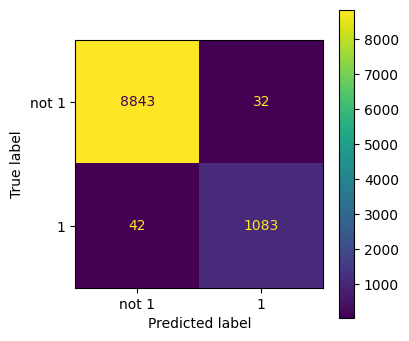

sensitivity_TPR:  0.9626666666666667
2 confusion matrix & metrics:


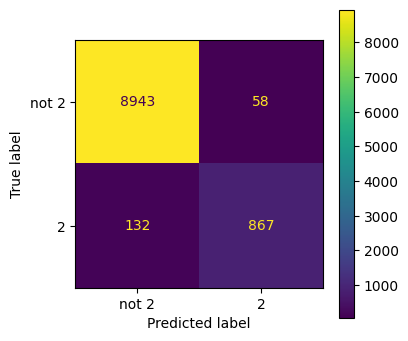

sensitivity_TPR:  0.8678678678678678
3 confusion matrix & metrics:


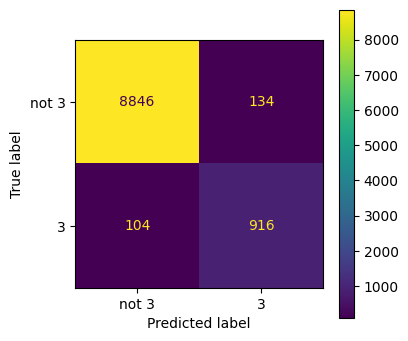

sensitivity_TPR:  0.8980392156862745
4 confusion matrix & metrics:


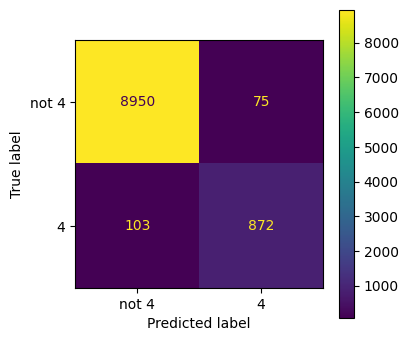

sensitivity_TPR:  0.8943589743589744
5 confusion matrix & metrics:


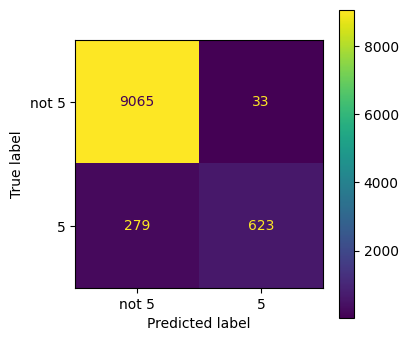

sensitivity_TPR:  0.6906873614190687
6 confusion matrix & metrics:


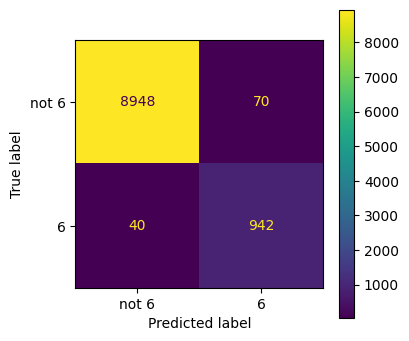

sensitivity_TPR:  0.9592668024439919
7 confusion matrix & metrics:


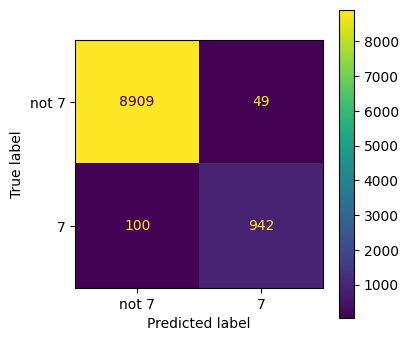

sensitivity_TPR:  0.9040307101727447
8 confusion matrix & metrics:


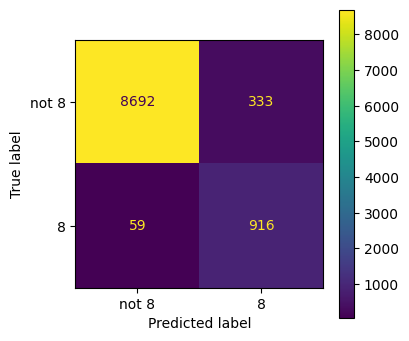

sensitivity_TPR:  0.9394871794871795
9 confusion matrix & metrics:


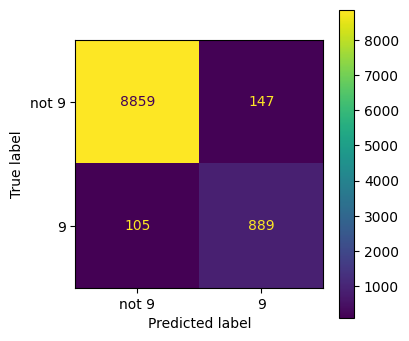

sensitivity_TPR:  0.8943661971830986


In [9]:
softmax_regression.my_confusion_matrix(y_test, y_hats)

# Conclusions
* I've run the model with 500 epochs and learninng rate of 0.5 and got 0.9005 accuracy.
* The total time to train the model is about 1 minute. 
* In addition, we can notice for a low TPR value for digit 5 (0.6906) while the other digits have higher TPR values between 0.8-1.0
* Maybe adding more training data for the digit 5 will improve the model's performance on digit 5.
* We can see that the diagonal of the confusion matrix has the highest values, which means that the model is good at classifying the digits to their true class.

## Display The errors while training
* Display in and out of sample errors on the same graph to see if the model is overfitting or not
* I chose to display the graph with x axis of number of epochs.

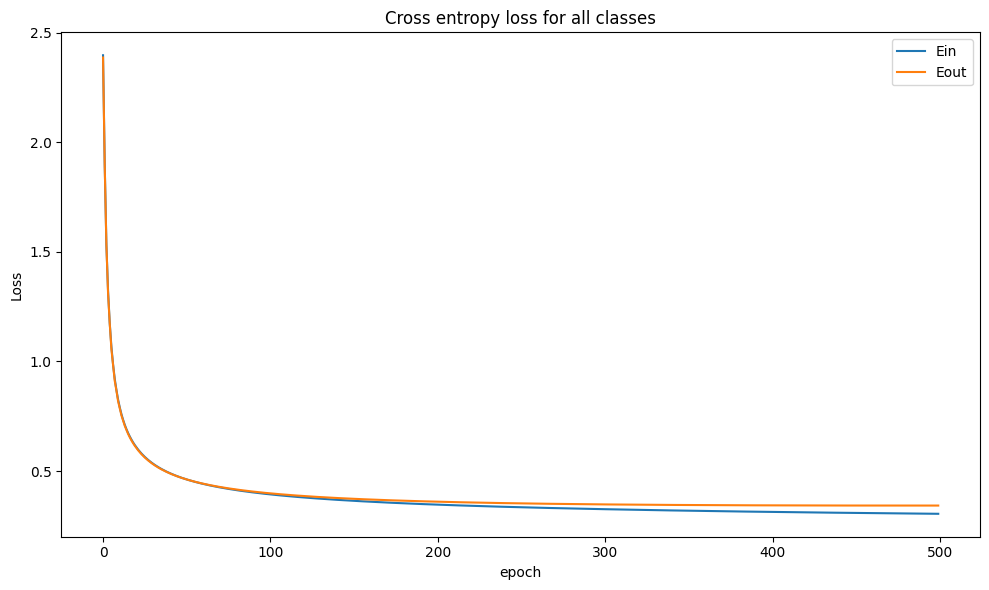

In [10]:
softmax_regression.plot_loss_for_all_classes()

* We can see the model converge to a low error value both for the training and test sets. 
* In addition we can see the at the end of the line the error is slightly lower for the training set than the test set, which is expected.
* The lower line of the training set could not be good and may indicate overfitting, but we can see that the difference between the two lines is not very big, so we can say that the model is not overfitting.

# Summary
* The accuracy of the softmax regression model with 500 iterations and 0.5 learning rate is 0.9005.
* It took approximately 1 minute for the model to converge.
* More optimization techniques can be used to gain higher metrics values, like early stopping, regularization, momentum, etc.
* trying to experiment changes in the parameters of the model can be helpful to get higher accuracy.

The softmax regression is faster and have better accuracy than the perceptron model and easy to implement and tune.
Also, the formulas are easy to implement than the perceptron model.